# Using Google Map API to scrape places details

Replace the String with your own API key

In [ ]:
api_key = "<__Your Google API Key__>" # Put your API key here

Import the module required

In [1]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import contextily as cx
import csv

### Spliting the Singapore's Boundary into grid.

The reason we are doing this is because the Google Map Places API only return 20 records a time. So if you are searching very general term such as "resturant" or "shop". It will probably more then 20 places within each grid. So it is better to set the box size smaller, so it will not leave places uncovered.

In [24]:
# The longitude and latitude of the corners of Singapore
SW_long, SW_lat = 103.5, 1.20
NE_long, NE_lat = 104.2, 1.48

# The size of the bounding boxes, the unit is in degrees, 1 degree is approximately 111km (111,139 meters)
box_width = 0.01
box_height = 0.01

# Initialize the southwest corner coordinates
sw_long, sw_lat = SW_long, SW_lat

# Initialize an empty list to store the bounding boxes
bounding_boxes = []
polygon =-gpd.GeoDataFrame()
while sw_lat < NE_lat: # when the southwest latitude is less than the northeast latitude (north of the equator)
    ne_lat = sw_lat + box_height
    while sw_long < NE_long:
        ne_long = sw_long + box_width
        bounding_boxes.append(((sw_long, sw_lat), (ne_long, ne_lat)))
        sw_long = ne_long
    sw_lat = ne_lat
    sw_long = SW_long

for box in bounding_boxes:
    lng1 = box[0][0]
    lat1 = box[0][1]
    lng2 = box[1][0]
    lat2 = box[1][1]
    polygon_geom = Polygon([(lng1, lat1), (lng2, lat1), (lng2, lat2), (lng1, lat2)])
    new_polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])
    #polygon = polygon.append(new_polygon, ignore_index=True)
    polygon = pd.concat([polygon, new_polygon], axis = 0, ignore_index=True)

In [25]:
print(len(bounding_boxes))
# 18
bounding_boxes[0]

1960


((103.5, 1.2), (103.51, 1.21))

<AxesSubplot: >

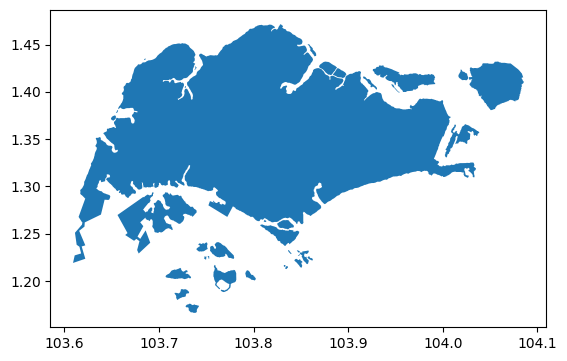

In [26]:
# read the shpfile
sg = gpd.read_file('Singapore_Boundary/Singapore_boundary.shp')
sg.plot()

<AxesSubplot: >

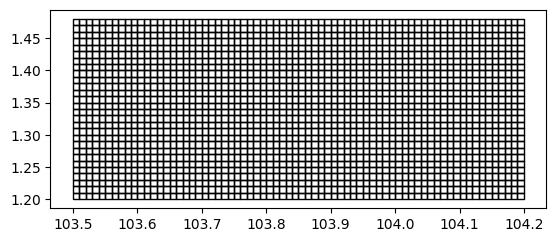

In [27]:
polygon.plot(edgecolor='black', facecolor='none')

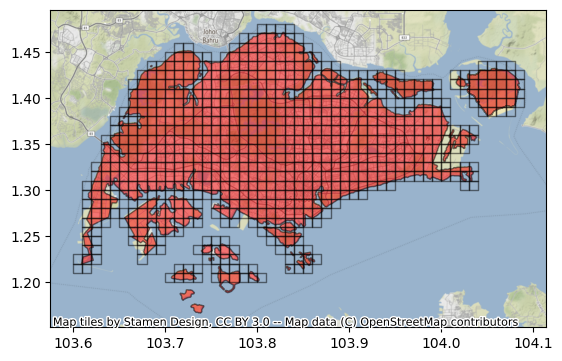

In [28]:
# select only polygons intersecting with Singapore
polygon = polygon[polygon.intersects(sg.geometry.unary_union)]

polygon.reset_index(drop=True, inplace=True)

ax = sg.plot(edgecolor='black', facecolor='red', alpha=0.5)
polygon.plot(ax = ax, edgecolor='black', facecolor='none', alpha=0.5, figsize=(10, 10))
cx.add_basemap(ax, crs="EPSG:4326")

C:\Users\libay\AppData\Local\Temp\ipykernel_25052\2996058809.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cent_grid = polygon['geometry'].centroid


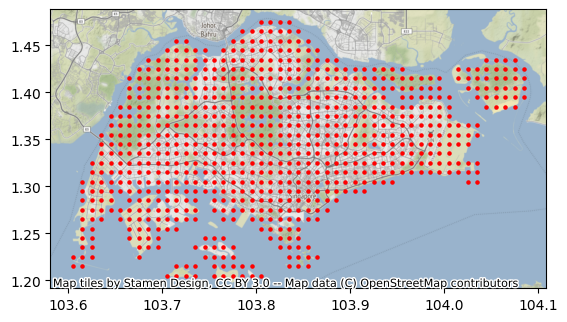

In [31]:
# Generate centroid from polygon
cent_grid = polygon['geometry'].centroid
cent_grid = gpd.GeoDataFrame(cent_grid, columns=['geometry'], crs='epsg:4326')

ax = cent_grid.plot(marker='o', color='red', markersize=5)
cx.add_basemap(ax, crs="EPSG:4326")

In [36]:
# search for bubble tea in the bounding boxes with Google Map API
# The API key
query = "KFC" # Put your search query here (keyword of the place you want to search)

# Initialize an empty list to store the results
results = []

for pt in range(len(cent_grid)):
    coords = cent_grid['geometry'][pt].coords
    coord_1 = coords[0][1]
    coord_2 = coords[0][0]

    # Make the API call
    url = f"https://maps.googleapis.com/maps/api/place/textsearch/json?query={query}&location={coord_1},{coord_2}&radius=1000&key={api_key}"

    response = requests.get(url)
    # Convert the response to JSON format and get the results
    places = response.json()['results']
    # Add the results to the list
    results += places

In [37]:
len(results)

15180

In [43]:
def get_place_data(place):
    bbt = pd.DataFrame(columns=['name', 'place_id', 'address', 'latitude', 'longitude', 'viewport_ne_lat', 'viewport_sw_lat', 'viewport_ne_lng', 'viewport_sw_lng', 'user_ratings_total', 'rating', 'price_level'])
    for data in results:
        address = data['formatted_address']
        lat = data['geometry']['location']['lat']
        lng = data['geometry']['location']['lng']
        name = data['name']
        place_id = data['place_id']
        viewport_ne_lat = data['geometry']['viewport']['northeast']['lat']
        viewport_ne_lng = data['geometry']['viewport']['northeast']['lng']
        viewport_sw_lat = data['geometry']['viewport']['southwest']['lat']
        viewport_sw_lng = data['geometry']['viewport']['southwest']['lng']
        user_ratings_total = data['user_ratings_total']
        rating = data['rating']
        # if the price level is not available, set it to 0
        if 'price_level' not in data:
            price_level = 0
        else:
            price_level = data['price_level']
        newrow = {
            'name': name,
            'place_id': place_id,
            'address': address,
            'latitude': lat,
            'longitude': lng,
            'viewport_ne_lat': viewport_ne_lat,
            'viewport_ne_lng': viewport_ne_lng,
            'viewport_sw_lat': viewport_sw_lat,
            'viewport_sw_lng': viewport_sw_lng,
            'user_ratings_total': user_ratings_total,
            'rating': rating,
            'price_level': price_level
        }
        newrow = pd.DataFrame(newrow, index=[0])
        bbt = pd.concat([bbt, newrow], axis =0, ignore_index=True)
    # remove duplicates based on place_id
    bbt_cleaned = bbt.drop_duplicates(subset='place_id', keep='first')
    # reset index
    bbt_cleaned.reset_index(drop=True, inplace=True)
    return bbt, bbt_cleaned

KFCs, KFCs_cleaned = get_place_data(results)  

In [44]:
KFCs

,name,place_id,address,latitude,longitude,viewport_ne_lat,viewport_sw_lat,viewport_ne_lng,viewport_sw_lng,user_ratings_total,rating,price_level
0,KFC Yung Ho,ChIJvQCp6FUF2jERIYOD-jddkQw,"18 Yung Ho Rd, Singapore 618591",1.326273,103.723827,1.327648,1.324948,103.725165,103.722465,908,3.7,2
1,KFC Clementi Mall,ChIJsx75zI8a2jER0TpRfwfJIUU,"3155 Commonwealth Ave W, B1-32/33, Singapore 1...",1.315412,103.764620,1.316752,1.314053,103.766072,103.763372,438,3.7,2
2,KFC Jalan Mas Puteh,ChIJXwEItZIa2jERrUdf7yR4oOY,"35 Jln Mas Puteh, Pasir Panjang Gardens, Singa...",1.308370,103.762237,1.309698,1.306999,103.763641,103.760942,204,3.6,2
3,KFC Jurong Point,ChIJmRnrx-wP2jERtLem-l0M7Rw,"1 Jurong West Central 2, #01 - 30 Jurong Point...",1.339637,103.706453,1.340880,1.338181,103.708859,103.702756,1334,3.9,2
4,KFC,ChIJF1YeYb0Z2jERsp652TMwYwE,"1 HarbourFront Walk, #B2, #32 VivoCity, Singap...",1.264403,103.822207,1.266087,1.263387,103.823727,103.821027,47,2.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15175,KFC Pasir Gudang Land Drive Thru,ChIJw74rqrVq2jERwLlrem5nY3A,"Plot 1, Block C, Jalan, Persiaran Dahlia 2, Ta...",1.481901,103.892131,1.483263,1.480563,103.893565,103.890865,1234,3.8,2
15176,KFC Giant Plentong,ChIJaWR8TXFs2jERkhLVai5n-tY,"Lot K7, Ground Floor, Giant Hypermarket Plento...",1.528101,103.814598,1.529706,1.527006,103.815641,103.812941,84,3.7,2
15177,KFC Petronas Jalan Masai DT,ChIJGy-o5ytt2jERPE23zDPkNwg,"Petronas, Lot PTD 173043 (D), 351588, 111466, ...",1.524520,103.816868,1.525814,1.523114,103.818253,103.815553,108,4.0,2
15178,KFC Pasir Gudang,ChIJUeq8XEUV2jER0rCa29r4azE,"Level 3-27B, Level, 3, Jalan Kompleks, Pusat B...",1.466590,103.901629,1.467905,1.465205,103.903056,103.900356,99,3.7,2


In [45]:
KFCs_cleaned

,name,place_id,address,latitude,longitude,viewport_ne_lat,viewport_sw_lat,viewport_ne_lng,viewport_sw_lng,user_ratings_total,rating,price_level
0,KFC Yung Ho,ChIJvQCp6FUF2jERIYOD-jddkQw,"18 Yung Ho Rd, Singapore 618591",1.326273,103.723827,1.327648,1.324948,103.725165,103.722465,908,3.7,2
1,KFC Clementi Mall,ChIJsx75zI8a2jER0TpRfwfJIUU,"3155 Commonwealth Ave W, B1-32/33, Singapore 1...",1.315412,103.764620,1.316752,1.314053,103.766072,103.763372,438,3.7,2
2,KFC Jalan Mas Puteh,ChIJXwEItZIa2jERrUdf7yR4oOY,"35 Jln Mas Puteh, Pasir Panjang Gardens, Singa...",1.308370,103.762237,1.309698,1.306999,103.763641,103.760942,204,3.6,2
3,KFC Jurong Point,ChIJmRnrx-wP2jERtLem-l0M7Rw,"1 Jurong West Central 2, #01 - 30 Jurong Point...",1.339637,103.706453,1.340880,1.338181,103.708859,103.702756,1334,3.9,2
4,KFC,ChIJF1YeYb0Z2jERsp652TMwYwE,"1 HarbourFront Walk, #B2, #32 VivoCity, Singap...",1.264403,103.822207,1.266087,1.263387,103.823727,103.821027,47,2.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
101,KFC Permas,ChIJpcb71J5s2jERXGChH2CXQzE,"15-02, No. 1,1-01, 1, Jalan Permas 10/1, Perma...",1.498259,103.816089,1.499609,1.496909,103.817503,103.814803,633,4.0,2
102,"KFC Lotus's Seri Alam, JB",ChIJ7WhBOeBq2jERYinoXjNiveM,"Lease 3, Jalan Seri Alam, Bandar Baru Seri Ala...",1.496984,103.869537,1.498170,1.495470,103.871147,103.868447,83,3.4,2
103,KFC Taman Molek,ChIJLYNc_U9s2jER9OM-ISsQqNs,"21, Jalan Molek 1/29, Taman Molek, 81100 Johor...",1.524126,103.786081,1.525429,1.522729,103.787470,103.784770,471,3.7,2
104,KFC Giant Plentong,ChIJaWR8TXFs2jERkhLVai5n-tY,"Lot K7, Ground Floor, Giant Hypermarket Plento...",1.528101,103.814598,1.529706,1.527006,103.815641,103.812941,84,3.7,2


In [48]:
# create a geodataframe from the dataframe
KFCs_cleaned_gdf = gpd.GeoDataFrame(KFCs_cleaned, geometry=gpd.points_from_xy(KFCs_cleaned.longitude, KFCs_cleaned.latitude))

# select only places intersecting with Singapore (There are many stores in JB close to Singapore)
KFCs_cleaned_gdf_sg = KFCs_cleaned_gdf[KFCs_cleaned_gdf.intersects(sg.geometry.unary_union)]

# export the gdf to shpfile
KFCs_cleaned_gdf.to_file('shpfile/KFCs_cleaned.shp')
KFCs_cleaned_gdf_sg.to_file('shpfile/KFCs_cleaned_sg.shp')

C:\Users\libay\AppData\Local\Temp\ipykernel_25052\381035114.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  KFCs_cleaned_gdf.to_file('shpfile/KFCs_cleaned.shp')
C:\Users\libay\AppData\Local\Temp\ipykernel_25052\381035114.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  KFCs_cleaned_gdf_sg.to_file('shpfile/KFCs_cleaned_sg.shp')


In [49]:
KFCs_cleaned_gdf_sg

,name,place_id,address,latitude,longitude,viewport_ne_lat,viewport_sw_lat,viewport_ne_lng,viewport_sw_lng,user_ratings_total,rating,price_level,geometry
0,KFC Yung Ho,ChIJvQCp6FUF2jERIYOD-jddkQw,"18 Yung Ho Rd, Singapore 618591",1.326273,103.723827,1.327648,1.324948,103.725165,103.722465,908,3.7,2,POINT (103.72383 1.32627)
1,KFC Clementi Mall,ChIJsx75zI8a2jER0TpRfwfJIUU,"3155 Commonwealth Ave W, B1-32/33, Singapore 1...",1.315412,103.764620,1.316752,1.314053,103.766072,103.763372,438,3.7,2,POINT (103.76462 1.31541)
2,KFC Jalan Mas Puteh,ChIJXwEItZIa2jERrUdf7yR4oOY,"35 Jln Mas Puteh, Pasir Panjang Gardens, Singa...",1.308370,103.762237,1.309698,1.306999,103.763641,103.760942,204,3.6,2,POINT (103.76224 1.30837)
3,KFC Jurong Point,ChIJmRnrx-wP2jERtLem-l0M7Rw,"1 Jurong West Central 2, #01 - 30 Jurong Point...",1.339637,103.706453,1.340880,1.338181,103.708859,103.702756,1334,3.9,2,POINT (103.70645 1.33964)
4,KFC,ChIJF1YeYb0Z2jERsp652TMwYwE,"1 HarbourFront Walk, #B2, #32 VivoCity, Singap...",1.264403,103.822207,1.266087,1.263387,103.823727,103.821027,47,2.5,0,POINT (103.82221 1.26440)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,KFC Sunplaza,ChIJ7cjSMX0T2jERtyhAXbevl_8,"30 Sembawang Dr, #01 - 25 Sun Plaza, Singapore...",1.448036,103.819285,1.449393,1.446694,103.820605,103.817906,640,3.7,2,POINT (103.81928 1.44804)
80,KFC Junction 9,ChIJ3_Zy4H8V2jERSXMpMT1B5Q4,"18 Yishun Avenue 9, #01-78/79, Junction Nine, ...",1.433221,103.841488,1.434733,1.432033,103.842982,103.840283,16,2.6,0,POINT (103.84149 1.43322)
81,KFC ADMIRALTY,ChIJU2-qn3UT2jERrjloH2v8HhY,"678A Woodlands Ave 6, 04 Admiralty Place, #01-...",1.440535,103.801746,1.441777,1.439077,103.803143,103.800443,178,3.7,2,POINT (103.80175 1.44054)
82,KFC Canberra Plaza,ChIJE62UZx8V2jER0MH_1-sX5ws,"133 Canberra View, #01-09 Canberra Plaza, Sing...",1.443542,103.830280,1.445029,1.442329,103.831795,103.829096,55,2.4,0,POINT (103.83028 1.44354)


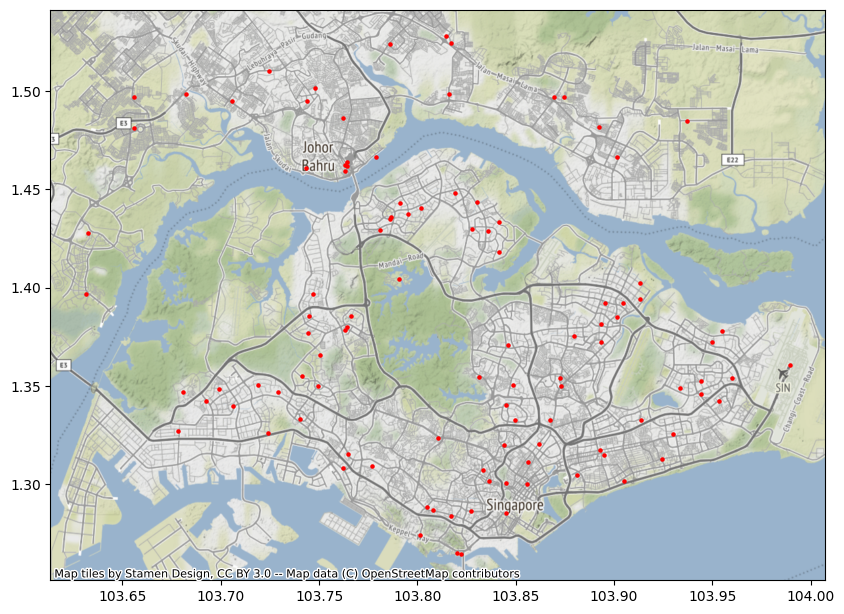

In [50]:
ax = KFCs_cleaned_gdf.plot(marker='o', color='red', markersize=5, figsize=(10, 10))
cx.add_basemap(ax, crs="EPSG:4326")

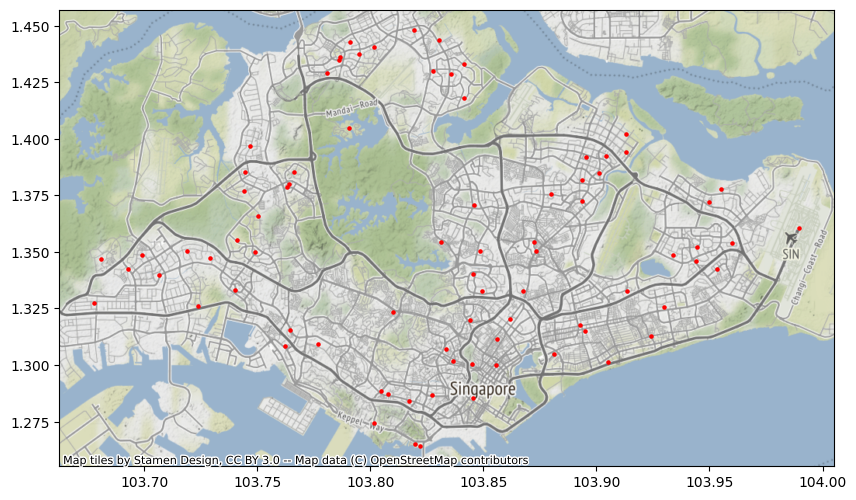

In [51]:
ax = KFCs_cleaned_gdf_sg.plot(marker='o', color='red', markersize=5, figsize=(10, 10))
cx.add_basemap(ax, crs="EPSG:4326")